In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import seaborn as sns
sns.set_theme()

In [4]:
plt.rcParams["figure.figsize"] = (15,9)

In [5]:
CALENDAR_PATH = os.path.abspath('../input/m5-forecasting-accuracy/calendar.csv')
SELL_PRICE_PATH = os.path.abspath('../input/m5-forecasting-accuracy/sell_prices.csv')
SALES_TV_PATH = os.path.abspath('../input/m5-forecasting-accuracy/sales_train_validation.csv')

In [6]:
df_calendar = pd.read_csv(CALENDAR_PATH)
df_calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [7]:
df_sell_price = pd.read_csv(SELL_PRICE_PATH)
df_sell_price.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [8]:
df_sales_tv = pd.read_csv(SALES_TV_PATH)
df_sales_tv.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [9]:
df_calendar.shape

(1969, 14)

In [10]:
df_sell_price.shape

(6841121, 4)

In [11]:
df_sales_tv.shape

(30490, 1919)

In [12]:
df_sell_price.drop(['store_id', 'item_id'], axis=1, inplace=True)

In [13]:
df_sell_price = df_sell_price.groupby('wm_yr_wk').agg(
        sales_price_min = ('sell_price', min),
        sales_price_max = ('sell_price', max),
        sales_price_mean = ('sell_price', np.mean)
).reset_index()

In [14]:
df_sell_price.head()

,wm_yr_wk,sales_price_min,sales_price_max,sales_price_mean
0,11101,0.20,22.0,4.071247
1,11102,0.20,28.0,4.161574
2,11103,0.07,28.0,4.190454
3,11104,0.07,28.0,4.200812
4,11105,0.16,28.0,4.202976


### Drop `event_name_2`, `event_type_2` and `wday` from `df_calendar`

In [15]:
df_calendar.drop(['event_name_1', 'event_name_2', 'event_type_2', 'wday', 'month', 'year'], axis=1, inplace=True)

In [16]:
df_calendar.head()

,date,wm_yr_wk,weekday,d,event_type_1,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,d_1,NaN,0,0,0
1,2011-01-30,11101,Sunday,d_2,NaN,0,0,0
2,2011-01-31,11101,Monday,d_3,NaN,0,0,0
3,2011-02-01,11101,Tuesday,d_4,NaN,1,1,0
4,2011-02-02,11101,Wednesday,d_5,NaN,1,0,1


In [17]:
df_calendar.isna().sum()

date               0
wm_yr_wk           0
weekday            0
d                  0
event_type_1    1807
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64

In [18]:
df_calendar.event_type_1.fillna('Daily', inplace=True)

# Downcast to save memory.

https://www.kaggle.com/code/anshuls235/time-series-forecasting-eda-fe-modelling

In [19]:
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df 

In [20]:
df_calendar = downcast(df_calendar)
df_sell_price = downcast(df_sell_price)
df_sales_tv = downcast(df_sales_tv)

## Merge `df_calendar` with `df_sell_price` on `wm_yr_wk`

In [21]:
df_calendar = df_calendar.merge(df_sell_price, how='left', on=['wm_yr_wk'])
df_calendar.head()

,date,wm_yr_wk,weekday,d,event_type_1,snap_CA,snap_TX,snap_WI,sales_price_min,sales_price_max,sales_price_mean
0,2011-01-29,11101,Saturday,d_1,Daily,0,0,0,0.199951,22.0,4.070312
1,2011-01-30,11101,Sunday,d_2,Daily,0,0,0,0.199951,22.0,4.070312
2,2011-01-31,11101,Monday,d_3,Daily,0,0,0,0.199951,22.0,4.070312
3,2011-02-01,11101,Tuesday,d_4,Daily,1,1,0,0.199951,22.0,4.070312
4,2011-02-02,11101,Wednesday,d_5,Daily,1,0,1,0.199951,22.0,4.070312


In [22]:
df_calendar.shape

(1969, 11)

In [23]:
df_calendar.duplicated().sum()

0

In [24]:
df_calendar.drop(['wm_yr_wk'], axis = 1, inplace = True)

In [25]:
df_calendar.set_index('d', inplace=True)
df_calendar.head()

,date,weekday,event_type_1,snap_CA,snap_TX,snap_WI,sales_price_min,sales_price_max,sales_price_mean
d,,,,,,,,,
d_1,2011-01-29,Saturday,Daily,0,0,0,0.199951,22.0,4.070312
d_2,2011-01-30,Sunday,Daily,0,0,0,0.199951,22.0,4.070312
d_3,2011-01-31,Monday,Daily,0,0,0,0.199951,22.0,4.070312
d_4,2011-02-01,Tuesday,Daily,1,1,0,0.199951,22.0,4.070312
d_5,2011-02-02,Wednesday,Daily,1,0,1,0.199951,22.0,4.070312


# Aggregate Modelling

First we will model over entire state `California`, `Texas` and `Wisconsin`.

## Data Prepration for LSTM Model

In [26]:
# Drop `id, item_id, dept_id, cat_id, store_id` from `df_sales_tv`
df_states = df_sales_tv.drop(['id', 'item_id', 'dept_id', 'cat_id', 'store_id'], axis = 1)
df_states.head()

,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,CA,0,0,0,0,0,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,CA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,CA,0,0,0,0,0,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,CA,0,0,0,0,0,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,CA,0,0,0,0,0,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [27]:
df_states = df_states.groupby('state_id').sum()
df_states.head()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
state_id,,,,,,,,,,,,,,,,,,,,,
CA,14195,13805,10108,11047,9925,11322,12251,16610,14696,11822,...,16255,20564,23032,17052.0,15784.0,15148.0,14488.0,17095,21834,23187
TX,9438,9630,6778,7381,5912,9006,6226,9440,9376,7319,...,10800,12460,13709,9868.0,10922.0,9600.0,9602.0,10615,12266,12282
WI,8998,8314,6897,6984,3309,8883,9533,11882,8664,6431,...,14734,15338,14899,11139.0,10864.0,10595.0,10943.0,12807,14862,14326


In [28]:
df_states.shape

(3, 1913)

In [29]:
def get_products_df(state_id):
    """
    This method gives product sold dataframe for given state_id.
    """        
    sample = df_states.loc[state_id, :].T
    sales_df = pd.merge(sample, df_calendar, left_index = True, right_index = True)
    sales_df = sales_df.reset_index()
    sales_df['date'] = pd.to_datetime(sales_df['date'])
    #sales_df['quarter'] = sales_df.date.dt.quarter.astype('uint8')
    sales_df.set_index('date', inplace = True)
    sales_df.drop(['index'], axis=1, inplace=True)
    if state_id == 'CA':
        sales_df.drop(['snap_TX', 'snap_WI'], axis = 1, inplace = True)
        sales_df.rename(columns={'snap_CA':'snap'}, inplace=True)
    if state_id == 'TX':
        sales_df.drop(['snap_CA', 'snap_WI'], axis = 1, inplace = True)
        sales_df.rename(columns={'snap_TX':'snap'}, inplace=True)
    if state_id == 'WI':
        sales_df.drop(['snap_TX', 'snap_CA'], axis = 1, inplace = True)
        sales_df.rename(columns={'snap_WI':'snap'}, inplace=True)
    return sales_df

In [30]:
df_california = get_products_df('CA')
df_california.head()

,CA,weekday,event_type_1,snap,sales_price_min,sales_price_max,sales_price_mean
date,,,,,,,
2011-01-29,14195.0,Saturday,Daily,0,0.199951,22.0,4.070312
2011-01-30,13805.0,Sunday,Daily,0,0.199951,22.0,4.070312
2011-01-31,10108.0,Monday,Daily,0,0.199951,22.0,4.070312
2011-02-01,11047.0,Tuesday,Daily,1,0.199951,22.0,4.070312
2011-02-02,9925.0,Wednesday,Daily,1,0.199951,22.0,4.070312


In [31]:
df_california.shape

(1913, 7)

In [32]:
df_california = pd.get_dummies(df_california, columns=['weekday', 'event_type_1'])
df_california.head()

,CA,snap,sales_price_min,sales_price_max,sales_price_mean,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,event_type_1_Cultural,event_type_1_Daily,event_type_1_National,event_type_1_Religious,event_type_1_Sporting
date,,,,,,,,,,,,,,,,,
2011-01-29,14195.0,0,0.199951,22.0,4.070312,0,0,1,0,0,0,0,0,1,0,0,0
2011-01-30,13805.0,0,0.199951,22.0,4.070312,0,0,0,1,0,0,0,0,1,0,0,0
2011-01-31,10108.0,0,0.199951,22.0,4.070312,0,1,0,0,0,0,0,0,1,0,0,0
2011-02-01,11047.0,1,0.199951,22.0,4.070312,0,0,0,0,0,1,0,0,1,0,0,0
2011-02-02,9925.0,1,0.199951,22.0,4.070312,0,0,0,0,0,0,1,0,1,0,0,0


In [33]:
df_california = downcast(df_california)

In [34]:
df_california.index.min()

Timestamp('2011-01-29 00:00:00')

In [35]:
df_california.index.max()

Timestamp('2016-04-24 00:00:00')

In [36]:
TRAIN_TEST_SPLIT = 1819

In [37]:
df_california_train = df_california.reset_index().loc[:TRAIN_TEST_SPLIT, :]

In [38]:
df_california_test = df_california.reset_index().loc[TRAIN_TEST_SPLIT:, :]

In [39]:
df_california_train.head()

,date,CA,snap,sales_price_min,sales_price_max,sales_price_mean,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,event_type_1_Cultural,event_type_1_Daily,event_type_1_National,event_type_1_Religious,event_type_1_Sporting
0,2011-01-29,14192.0,0,0.199951,22.0,4.070312,0,0,1,0,0,0,0,0,1,0,0,0
1,2011-01-30,13808.0,0,0.199951,22.0,4.070312,0,0,0,1,0,0,0,0,1,0,0,0
2,2011-01-31,10112.0,0,0.199951,22.0,4.070312,0,1,0,0,0,0,0,0,1,0,0,0
3,2011-02-01,11048.0,1,0.199951,22.0,4.070312,0,0,0,0,0,1,0,0,1,0,0,0
4,2011-02-02,9928.0,1,0.199951,22.0,4.070312,0,0,0,0,0,0,1,0,1,0,0,0


## Create Lagged Feature

In [40]:
for i in range(1, 29):
    df_california_train[f'CA_lagged_{i}'] = df_california_train['CA'].shift(-1*i)

In [41]:
for i in range(1, 29):
    df_california_test[f'CA_lagged_{i}'] = df_california_test['CA'].shift(-1*i)

### Drop NaNs created because of lagged feature.

In [42]:
df_california_train.shape

(1820, 46)

In [43]:
df_california_train.isna().sum()

date                       0
CA                         0
snap                       0
sales_price_min            0
sales_price_max            0
sales_price_mean           0
weekday_Friday             0
weekday_Monday             0
weekday_Saturday           0
weekday_Sunday             0
weekday_Thursday           0
weekday_Tuesday            0
weekday_Wednesday          0
event_type_1_Cultural      0
event_type_1_Daily         0
event_type_1_National      0
event_type_1_Religious     0
event_type_1_Sporting      0
CA_lagged_1                1
CA_lagged_2                2
CA_lagged_3                3
CA_lagged_4                4
CA_lagged_5                5
CA_lagged_6                6
CA_lagged_7                7
CA_lagged_8                8
CA_lagged_9                9
CA_lagged_10              10
CA_lagged_11              11
CA_lagged_12              12
CA_lagged_13              13
CA_lagged_14              14
CA_lagged_15              15
CA_lagged_16              16
CA_lagged_17  

In [44]:
df_california_train.dropna(inplace = True)

In [45]:
df_california_train.shape

(1792, 46)

In [46]:
df_california_test.shape

(94, 46)

In [47]:
df_california_test.dropna(inplace = True)

In [48]:
df_california_test.shape

(66, 46)

## Scale Numerical Columns

In [49]:
cols_to_scale = ['sales_price_min', 'sales_price_max', 'sales_price_mean']

In [50]:
# Add lagged columns except for 28

lagged_columns = []
lagged_columns.append('CA')
for i in range(1, 28):
    lagged_columns.append(f'CA_lagged_{i}')
    
cols_to_scale = cols_to_scale + lagged_columns
cols_to_scale

['sales_price_min',
 'sales_price_max',
 'sales_price_mean',
 'CA',
 'CA_lagged_1',
 'CA_lagged_2',
 'CA_lagged_3',
 'CA_lagged_4',
 'CA_lagged_5',
 'CA_lagged_6',
 'CA_lagged_7',
 'CA_lagged_8',
 'CA_lagged_9',
 'CA_lagged_10',
 'CA_lagged_11',
 'CA_lagged_12',
 'CA_lagged_13',
 'CA_lagged_14',
 'CA_lagged_15',
 'CA_lagged_16',
 'CA_lagged_17',
 'CA_lagged_18',
 'CA_lagged_19',
 'CA_lagged_20',
 'CA_lagged_21',
 'CA_lagged_22',
 'CA_lagged_23',
 'CA_lagged_24',
 'CA_lagged_25',
 'CA_lagged_26',
 'CA_lagged_27']

In [51]:
from sklearn.preprocessing import MinMaxScaler

In [52]:
standard_scaler = MinMaxScaler()

In [53]:
df_california_train[cols_to_scale] = standard_scaler.fit_transform(df_california_train[cols_to_scale])
df_california_train.head()

,date,CA,snap,sales_price_min,sales_price_max,sales_price_mean,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,...,CA_lagged_19,CA_lagged_20,CA_lagged_21,CA_lagged_22,CA_lagged_23,CA_lagged_24,CA_lagged_25,CA_lagged_26,CA_lagged_27,CA_lagged_28
0,2011-01-29,0.573730,0,1.0,0.0,0.0,0,0,1,0,...,0.316406,0.404785,0.560547,0.543945,0.484619,0.368652,0.361084,0.343750,0.397705,13648.0
1,2011-01-30,0.558105,0,1.0,0.0,0.0,0,0,0,1,...,0.404785,0.560547,0.543945,0.484619,0.368652,0.361084,0.343750,0.397705,0.551758,12488.0
2,2011-01-31,0.408447,0,1.0,0.0,0.0,0,1,0,0,...,0.560547,0.543945,0.484619,0.368652,0.361084,0.343750,0.397705,0.551758,0.504883,9200.0
3,2011-02-01,0.446289,1,1.0,0.0,0.0,0,0,0,0,...,0.543945,0.484619,0.368652,0.361084,0.343750,0.397705,0.551758,0.504883,0.371582,9784.0
4,2011-02-02,0.400879,1,1.0,0.0,0.0,0,0,0,0,...,0.484619,0.368652,0.361084,0.343750,0.397705,0.551758,0.504883,0.371582,0.395264,9536.0


In [54]:
df_california_test[cols_to_scale] = standard_scaler.fit_transform(df_california_test[cols_to_scale])
df_california_test.head()

,date,CA,snap,sales_price_min,sales_price_max,sales_price_mean,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,...,CA_lagged_19,CA_lagged_20,CA_lagged_21,CA_lagged_22,CA_lagged_23,CA_lagged_24,CA_lagged_25,CA_lagged_26,CA_lagged_27,CA_lagged_28
1819,2016-01-22,0.116211,0,1.0,0.0,0.007812,1,0,0,0,...,0.211914,0.267578,0.259766,0.702148,0.469727,0.469727,0.116211,0.054688,0.121094,17120.0
1820,2016-01-23,0.792969,0,1.0,0.0,0.007812,0,0,1,0,...,0.267578,0.259766,0.702148,0.469727,0.469727,0.116211,0.054688,0.121094,0.282227,21344.0
1821,2016-01-24,0.705078,0,1.0,0.0,0.007812,0,0,0,1,...,0.259766,0.702148,0.469727,0.469727,0.116211,0.054688,0.121094,0.282227,0.656250,22544.0
1822,2016-01-25,0.180664,0,1.0,0.0,0.007812,0,1,0,0,...,0.702148,0.469727,0.469727,0.116211,0.054688,0.121094,0.282227,0.656250,0.762695,16272.0
1823,2016-01-26,0.008789,0,1.0,0.0,0.007812,0,0,0,0,...,0.469727,0.469727,0.116211,0.054688,0.121094,0.282227,0.656250,0.762695,0.207031,14616.0


In [55]:
df_california_train.shape

(1792, 46)

In [56]:
df_california_test.shape

(66, 46)

In [57]:
california_train_dates = df_california_train['date'].values
california_train_dates

array(['2011-01-29T00:00:00.000000000', '2011-01-30T00:00:00.000000000',
       '2011-01-31T00:00:00.000000000', ...,
       '2015-12-23T00:00:00.000000000', '2015-12-24T00:00:00.000000000',
       '2015-12-25T00:00:00.000000000'], dtype='datetime64[ns]')

In [58]:
california_test_dates = df_california_test['date'].values
california_test_dates

array(['2016-01-22T00:00:00.000000000', '2016-01-23T00:00:00.000000000',
       '2016-01-24T00:00:00.000000000', '2016-01-25T00:00:00.000000000',
       '2016-01-26T00:00:00.000000000', '2016-01-27T00:00:00.000000000',
       '2016-01-28T00:00:00.000000000', '2016-01-29T00:00:00.000000000',
       '2016-01-30T00:00:00.000000000', '2016-01-31T00:00:00.000000000',
       '2016-02-01T00:00:00.000000000', '2016-02-02T00:00:00.000000000',
       '2016-02-03T00:00:00.000000000', '2016-02-04T00:00:00.000000000',
       '2016-02-05T00:00:00.000000000', '2016-02-06T00:00:00.000000000',
       '2016-02-07T00:00:00.000000000', '2016-02-08T00:00:00.000000000',
       '2016-02-09T00:00:00.000000000', '2016-02-10T00:00:00.000000000',
       '2016-02-11T00:00:00.000000000', '2016-02-12T00:00:00.000000000',
       '2016-02-13T00:00:00.000000000', '2016-02-14T00:00:00.000000000',
       '2016-02-15T00:00:00.000000000', '2016-02-16T00:00:00.000000000',
       '2016-02-17T00:00:00.000000000', '2016-02-18

# Drop Date Column

In [59]:
df_california_train.drop(['date'], axis=1, inplace=True)
df_california_test.drop(['date'], axis=1, inplace=True)

In [60]:
train_y = df_california_train[['CA_lagged_28']].values
test_y = df_california_test[['CA_lagged_28']].values

In [61]:
train_y

array([[13648.],
       [12488.],
       [ 9200.],
       ...,
       [14240.],
       [13936.],
       [15104.]], dtype=float16)

In [62]:
test_y

array([[17120.],
       [21344.],
       [22544.],
       [16272.],
       [14616.],
       [13944.],
       [14520.],
       [16344.],
       [21552.],
       [23152.],
       [16232.],
       [16296.],
       [15416.],
       [15624.],
       [16096.],
       [22016.],
       [25216.],
       [17152.],
       [16080.],
       [15544.],
       [15832.],
       [16272.],
       [22512.],
       [21936.],
       [16864.],
       [15048.],
       [14808.],
       [14192.],
       [16672.],
       [18896.],
       [19424.],
       [16544.],
       [15584.],
       [15144.],
       [15232.],
       [18688.],
       [23792.],
       [21296.],
       [15480.],
       [15320.],
       [14352.],
       [15600.],
       [18928.],
       [22176.],
       [24576.],
       [18192.],
       [16400.],
       [15808.],
       [15456.],
       [17712.],
       [23312.],
       [24064.],
       [17488.],
       [15192.],
       [14616.],
       [15072.],
       [16256.],
       [20560.],
       [23040.

In [63]:
train_x = df_california_train.drop(['CA_lagged_28'], axis = 1)
test_x = df_california_test.drop(['CA_lagged_28'], axis = 1)

In [64]:
train_x

,CA,snap,sales_price_min,sales_price_max,sales_price_mean,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,...,CA_lagged_18,CA_lagged_19,CA_lagged_20,CA_lagged_21,CA_lagged_22,CA_lagged_23,CA_lagged_24,CA_lagged_25,CA_lagged_26,CA_lagged_27
0,0.573730,0,1.0,0.000000,0.0,0,0,1,0,0,...,0.357422,0.316406,0.404785,0.560547,0.543945,0.484619,0.368652,0.361084,0.343750,0.397705
1,0.558105,0,1.0,0.000000,0.0,0,0,0,1,0,...,0.316406,0.404785,0.560547,0.543945,0.484619,0.368652,0.361084,0.343750,0.397705,0.551758
2,0.408447,0,1.0,0.000000,0.0,0,1,0,0,0,...,0.404785,0.560547,0.543945,0.484619,0.368652,0.361084,0.343750,0.397705,0.551758,0.504883
3,0.446289,1,1.0,0.000000,0.0,0,0,0,0,0,...,0.560547,0.543945,0.484619,0.368652,0.361084,0.343750,0.397705,0.551758,0.504883,0.371582
4,0.400879,1,1.0,0.000000,0.0,0,0,0,0,0,...,0.543945,0.484619,0.368652,0.361084,0.343750,0.397705,0.551758,0.504883,0.371582,0.395264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1787,0.623047,0,1.0,0.093262,1.0,0,1,0,0,0,...,0.656250,0.926758,0.897461,0.654785,0.567871,0.525391,0.540039,0.638672,0.863770,0.842285
1788,0.647461,0,1.0,0.093262,1.0,0,0,0,0,0,...,0.926758,0.897461,0.654785,0.567871,0.525391,0.540039,0.638672,0.863770,0.842285,0.727539
1789,0.667969,0,1.0,0.093262,1.0,0,0,0,0,0,...,0.897461,0.654785,0.567871,0.525391,0.540039,0.638672,0.863770,0.842285,0.727539,0.541016
1790,0.559082,0,1.0,0.093262,1.0,0,0,0,0,1,...,0.654785,0.567871,0.525391,0.540039,0.638672,0.863770,0.842285,0.727539,0.541016,0.575684


In [65]:
test_x

,CA,snap,sales_price_min,sales_price_max,sales_price_mean,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,...,CA_lagged_18,CA_lagged_19,CA_lagged_20,CA_lagged_21,CA_lagged_22,CA_lagged_23,CA_lagged_24,CA_lagged_25,CA_lagged_26,CA_lagged_27
1819,0.116211,0,1.0,0.0,0.007812,1,0,0,0,0,...,0.145508,0.211914,0.267578,0.259766,0.702148,0.469727,0.469727,0.116211,0.054688,0.121094
1820,0.792969,0,1.0,0.0,0.007812,0,0,1,0,0,...,0.211914,0.267578,0.259766,0.702148,0.469727,0.469727,0.116211,0.054688,0.121094,0.282227
1821,0.705078,0,1.0,0.0,0.007812,0,0,0,1,0,...,0.267578,0.259766,0.702148,0.469727,0.469727,0.116211,0.054688,0.121094,0.282227,0.656250
1822,0.180664,0,1.0,0.0,0.007812,0,1,0,0,0,...,0.259766,0.702148,0.469727,0.469727,0.116211,0.054688,0.121094,0.282227,0.656250,0.762695
1823,0.008789,0,1.0,0.0,0.007812,0,0,0,0,0,...,0.702148,0.469727,0.469727,0.116211,0.054688,0.121094,0.282227,0.656250,0.762695,0.207031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,0.120117,0,0.0,0.0,0.000000,0,0,0,0,0,...,0.898438,0.314453,0.111328,0.059570,0.100586,0.205078,0.586914,0.806641,0.276367,0.164062
1881,0.127930,0,0.0,0.0,0.000000,0,0,0,0,1,...,0.314453,0.111328,0.059570,0.100586,0.205078,0.586914,0.806641,0.276367,0.164062,0.107422
1882,0.429688,0,0.0,0.0,0.000000,1,0,0,0,0,...,0.111328,0.059570,0.100586,0.205078,0.586914,0.806641,0.276367,0.164062,0.107422,0.048828
1883,0.875000,0,0.0,0.0,0.000000,0,0,1,0,0,...,0.059570,0.100586,0.205078,0.586914,0.806641,0.276367,0.164062,0.107422,0.048828,0.279297


## Create Data for LSTM

In [66]:
train_X = []
train_Y = []
test_X = []
test_Y = []

# Look for past 28 days to predict next 28 days

In [67]:
n_future = 28
n_past = 28

In [68]:
train_x.shape

(1792, 44)

In [69]:
train_y.shape

(1792, 1)

In [70]:
train_x_processed = train_x.values
test_x_processed = test_x.values

In [71]:
train_x_processed.shape

(1792, 44)

In [72]:
test_x_processed.shape

(66, 44)

In [73]:
for i in range(n_past, len(train_x_processed) - n_future + 1):
    train_X.append(train_x_processed[i - n_past:i, 0:train_x_processed.shape[1]])
    train_Y.append(train_y[i + n_future - 1:i+n_future, 0])

In [74]:
for i in range(n_past, len(test_x_processed) - n_future + 1):
    test_X.append(test_x_processed[i - n_past:i, 0:test_x_processed.shape[1]])
    test_Y.append(test_y[i + n_future - 1:i+n_future, 0])

In [75]:
train_X, train_Y = np.array(train_X), np.array(train_Y)
test_X, test_Y = np.array(test_X), np.array(test_Y)

In [76]:
train_X.shape

(1737, 28, 44)

In [77]:
test_X.shape

(11, 28, 44)

In [78]:
test_X

array([[[0.1162 , 0.     , 1.     , ..., 0.1162 , 0.0547 , 0.1211 ],
        [0.793  , 0.     , 1.     , ..., 0.0547 , 0.1211 , 0.2822 ],
        [0.705  , 0.     , 1.     , ..., 0.1211 , 0.2822 , 0.6562 ],
        ...,
        [0.1289 , 0.     , 1.     , ..., 0.7607 , 0.709  , 0.2598 ],
        [0.06836, 0.     , 1.     , ..., 0.709  , 0.2598 , 0.09863],
        [0.1338 , 0.     , 1.     , ..., 0.2598 , 0.09863, 0.07715]],

       [[0.793  , 0.     , 1.     , ..., 0.0547 , 0.1211 , 0.2822 ],
        [0.705  , 0.     , 1.     , ..., 0.1211 , 0.2822 , 0.6562 ],
        [0.1807 , 0.     , 1.     , ..., 0.2822 , 0.6562 , 0.7627 ],
        ...,
        [0.06836, 0.     , 1.     , ..., 0.709  , 0.2598 , 0.09863],
        [0.1338 , 0.     , 1.     , ..., 0.2598 , 0.09863, 0.07715],
        [0.293  , 0.     , 1.     , ..., 0.09863, 0.07715, 0.02246]],

       [[0.705  , 0.     , 1.     , ..., 0.1211 , 0.2822 , 0.6562 ],
        [0.1807 , 0.     , 1.     , ..., 0.2822 , 0.6562 , 0.7627 ],
    

In [79]:
train_Y.shape

(1737, 1)

In [80]:
train_Y

array([[10968.],
       [13576.],
       [11720.],
       ...,
       [14240.],
       [13936.],
       [15104.]], dtype=float16)

In [81]:
test_Y.shape

(11, 1)

In [82]:
test_Y

array([[15072.],
       [16256.],
       [20560.],
       [23040.],
       [17056.],
       [15784.],
       [15152.],
       [14488.],
       [17088.],
       [21840.],
       [23184.]], dtype=float16)

## LSTM Modelling

In [83]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed 

In [84]:
from tensorflow.keras.models import Sequential

In [85]:
tf.keras.backend.clear_session()

In [86]:
model_CA = Sequential()
model_CA.add(LSTM(256, activation='relu', input_shape = (train_X.shape[1], train_X.shape[2]), return_sequences=True))
model_CA.add(LSTM(128, activation='relu'))
model_CA.add(RepeatVector(train_Y.shape[1]))
model_CA.add(LSTM(128, activation='relu', return_sequences=True))
model_CA.add(LSTM(256, activation='relu', return_sequences=True))
model_CA.add(TimeDistributed(Dense(256, activation='relu')))
model_CA.add(TimeDistributed(Dense(128, activation='relu')))
model_CA.add(TimeDistributed(Dense(1)))

adam = tf.keras.optimizers.Adam(learning_rate=1e-4)
model_CA.compile(optimizer=adam, loss = ['mae'])
model_CA.summary()

2022-12-08 03:50:54.132411: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 28, 256)           308224    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 128)            131584    
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 256)            394240    
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 256)            65792     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 128)            3

## Callbacks

In [87]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [88]:
checkpoint = ModelCheckpoint('M5_LSTM_CA.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience = 30)

In [89]:
history = model_CA.fit(train_X, train_Y, epochs=30, batch_size=16, validation_data=(test_X, test_Y), verbose= 1, callbacks=[checkpoint])

Epoch 1/30


2022-12-08 03:50:54.749859: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


109/109 [==============================] - 15s 83ms/step - loss: 12090.8770 - val_loss: 15915.5742

Epoch 00001: val_loss improved from inf to 15915.57422, saving model to M5_LSTM_CA.h5
Epoch 2/30
109/109 [==============================] - 8s 72ms/step - loss: 3838.7812 - val_loss: 15491.7617

Epoch 00002: val_loss improved from 15915.57422 to 15491.76172, saving model to M5_LSTM_CA.h5
Epoch 3/30
109/109 [==============================] - 8s 71ms/step - loss: 3341.3259 - val_loss: 15355.2715

Epoch 00003: val_loss improved from 15491.76172 to 15355.27148, saving model to M5_LSTM_CA.h5
Epoch 4/30
109/109 [==============================] - 9s 80ms/step - loss: 3167.4885 - val_loss: 14653.7490

Epoch 00004: val_loss improved from 15355.27148 to 14653.74902, saving model to M5_LSTM_CA.h5
Epoch 5/30
109/109 [==============================] - 8s 72ms/step - loss: 2913.9741 - val_loss: 8528.9854

Epoch 00005: val_loss improved from 14653.74902 to 8528.98535, saving model to M5_LSTM_CA.h5
Epoc

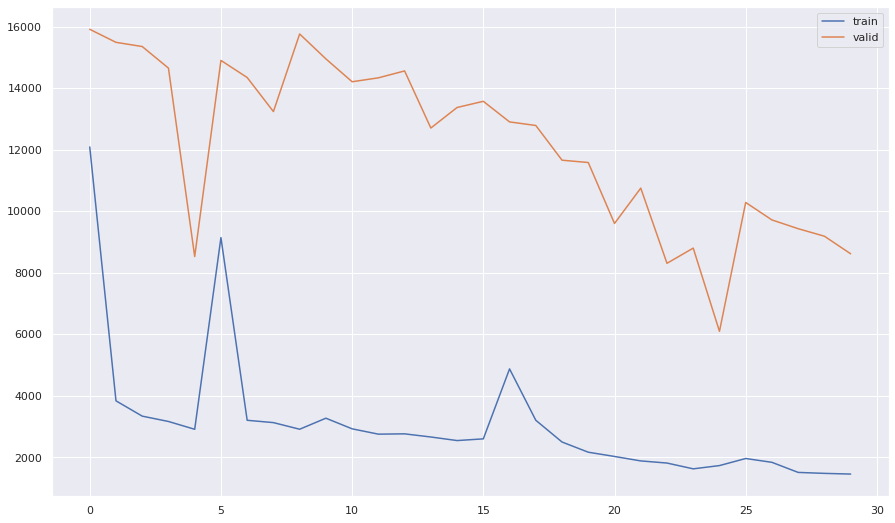

In [90]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()

In [91]:
from tensorflow.keras.models import load_model

In [92]:
model_CA = load_model('M5_LSTM_CA.h5')

In [93]:
pred_y = model_CA.predict(test_X)
pred_y

array([[[11189.115 ]],

       [[13437.897 ]],

       [[13646.486 ]],

       [[14546.865 ]],

       [[13339.686 ]],

       [[ 9461.587 ]],

       [[ 9478.7705]],

       [[ 9472.623 ]],

       [[10304.418 ]],

       [[13857.479 ]],

       [[13711.328 ]]], dtype=float32)

In [94]:
from sklearn.metrics import mean_absolute_error

In [95]:
pred_y.shape

(11, 1, 1)

In [96]:
pred_y = pred_y.reshape(test_Y.shape)

In [97]:
pred_y.shape

(11, 1)

In [98]:
test_Y.shape

(11, 1)

In [99]:
mean_absolute_error(test_Y, pred_y)

6097.613

# Some Visualization of Results

In [100]:
df_california_predicted = pd.DataFrame(list(zip(list(test_Y[:, 0]), list(pred_y[:, 0]))), columns = ['true_sales', 'predicted_sales'])
df_california_predicted.head()

,true_sales,predicted_sales
0,15072.0,11189.115234
1,16256.0,13437.897461
2,20560.0,13646.486328
3,23040.0,14546.865234
4,17056.0,13339.685547


In [101]:
df_california_predicted['date'] = california_test_dates[-11:]

In [102]:
df_california_predicted.set_index('date', inplace = True, drop = True)
df_california_predicted.head()

,true_sales,predicted_sales
date,,
2016-03-17,15072.0,11189.115234
2016-03-18,16256.0,13437.897461
2016-03-19,20560.0,13646.486328
2016-03-20,23040.0,14546.865234
2016-03-21,17056.0,13339.685547


Text(0.5, 1.0, 'California True vs Predicted Sales for 28 Days')

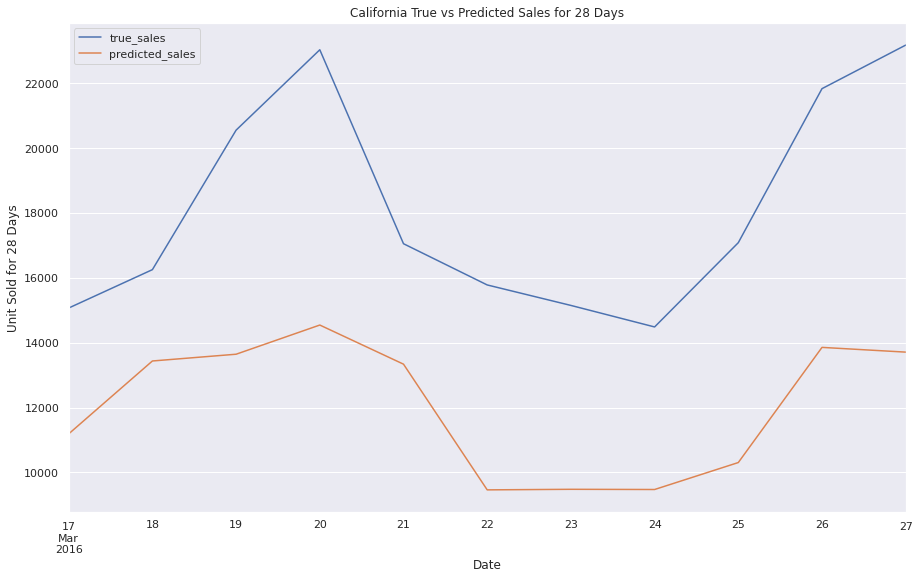

In [103]:
df_california_predicted.plot()
plt.xlabel('Date')
plt.ylabel('Unit Sold for 28 Days')
plt.title('California True vs Predicted Sales for 28 Days')

# Explaining Predictions